In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Load datasets
filepath_train_test = './train_test_data/dataset.csv'
filepath_validation = "./validation_data/dataset.csv"

df = pd.read_csv(filepath_train_test)
df_validation = pd.read_csv(filepath_validation)


In [2]:
# Aligning the datasets

# Find the difference in columns
unique_to_df1 = df.columns.difference(df_validation.columns)
unique_to_df2 = df_validation.columns.difference(df.columns)

# Drop the unique columns from each dataframe and sort columns
df = df.drop(columns=unique_to_df1)
df_validation = df_validation.drop(columns=unique_to_df2)
df_validation = df_validation[df.columns]

df.drop('_time', axis=1, inplace=True)
df_validation.drop('_time', axis=1, inplace=True)

In [3]:
# Prepare datasets for modeling and prediction

# Using only net metrics
net_columns = [col for col in df.columns if col.startswith('net') or col.startswith('5xx')]
df_net = df[net_columns]
df_net_validation = df_validation[net_columns]

# Get X and y
y = df_net['5xx_lag_agg']
X = df_net.drop('5xx_lag_agg', axis=1)

# Get X and y for validation set
y_val = df_net_validation['5xx_lag_agg']
X_val = df_net_validation.drop('5xx_lag_agg', axis=1)

# Perform the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# # Use SMOTE for oversampling minority classes
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [4]:
# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf.fit(X_train, y_train)

test_set = [X_test, y_test]
val_set = [X_val, y_val]

for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))


Dataset:  test_set

Accuracy: 0.33723196881091616
              precision    recall  f1-score   support

           0       0.55      0.45      0.50       262
           1       0.21      0.23      0.22        82
           2       0.17      0.25      0.21        71
           3       0.17      0.18      0.18        98

    accuracy                           0.34       513
   macro avg       0.28      0.28      0.28       513
weighted avg       0.37      0.34      0.35       513

Macro-Averaged F1-Score: 0.2750513538748833

AUC-ROC: 0.5283331799737343

Confusion Matrix:
[[118  45  50  49]
 [ 32  19  10  21]
 [ 25  10  18  18]
 [ 39  15  26  18]]

Dataset:  val_set

Accuracy: 0.34710743801652894
              precision    recall  f1-score   support

           0       0.62      0.44      0.51      1584
           1       0.16      0.16      0.16       454
           2       0.06      0.20      0.09       133
           3       0.17      0.23      0.19       370

    accuracy           

In [5]:
# Grid search cross validation
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 200],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 5600 candidates, totalling 16800 fits
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, criterion

In [6]:
# Use the best parameters from the grid search
# {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 90}
# best_params = grid_search.best_params_
best_params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 90}
rf = RandomForestClassifier(**best_params, random_state=0)

rf.fit(X_train, y_train)

# Make predictions and evaluate
for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))



Dataset:  test_set

Accuracy: 0.33528265107212474
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       262
           1       0.16      0.17      0.17        82
           2       0.17      0.23      0.19        71
           3       0.18      0.17      0.18        98

    accuracy                           0.34       513
   macro avg       0.26      0.26      0.26       513
weighted avg       0.35      0.34      0.34       513

Macro-Averaged F1-Score: 0.2591728474868445

AUC-ROC: 0.5133003642001273

Confusion Matrix:
[[125  48  44  45]
 [ 36  14  12  20]
 [ 36   7  16  12]
 [ 42  17  22  17]]

Dataset:  val_set

Accuracy: 0.3691460055096419
              precision    recall  f1-score   support

           0       0.62      0.49      0.54      1584
           1       0.15      0.15      0.15       454
           2       0.05      0.14      0.07       133
           3       0.17      0.22      0.19       370

    accuracy            

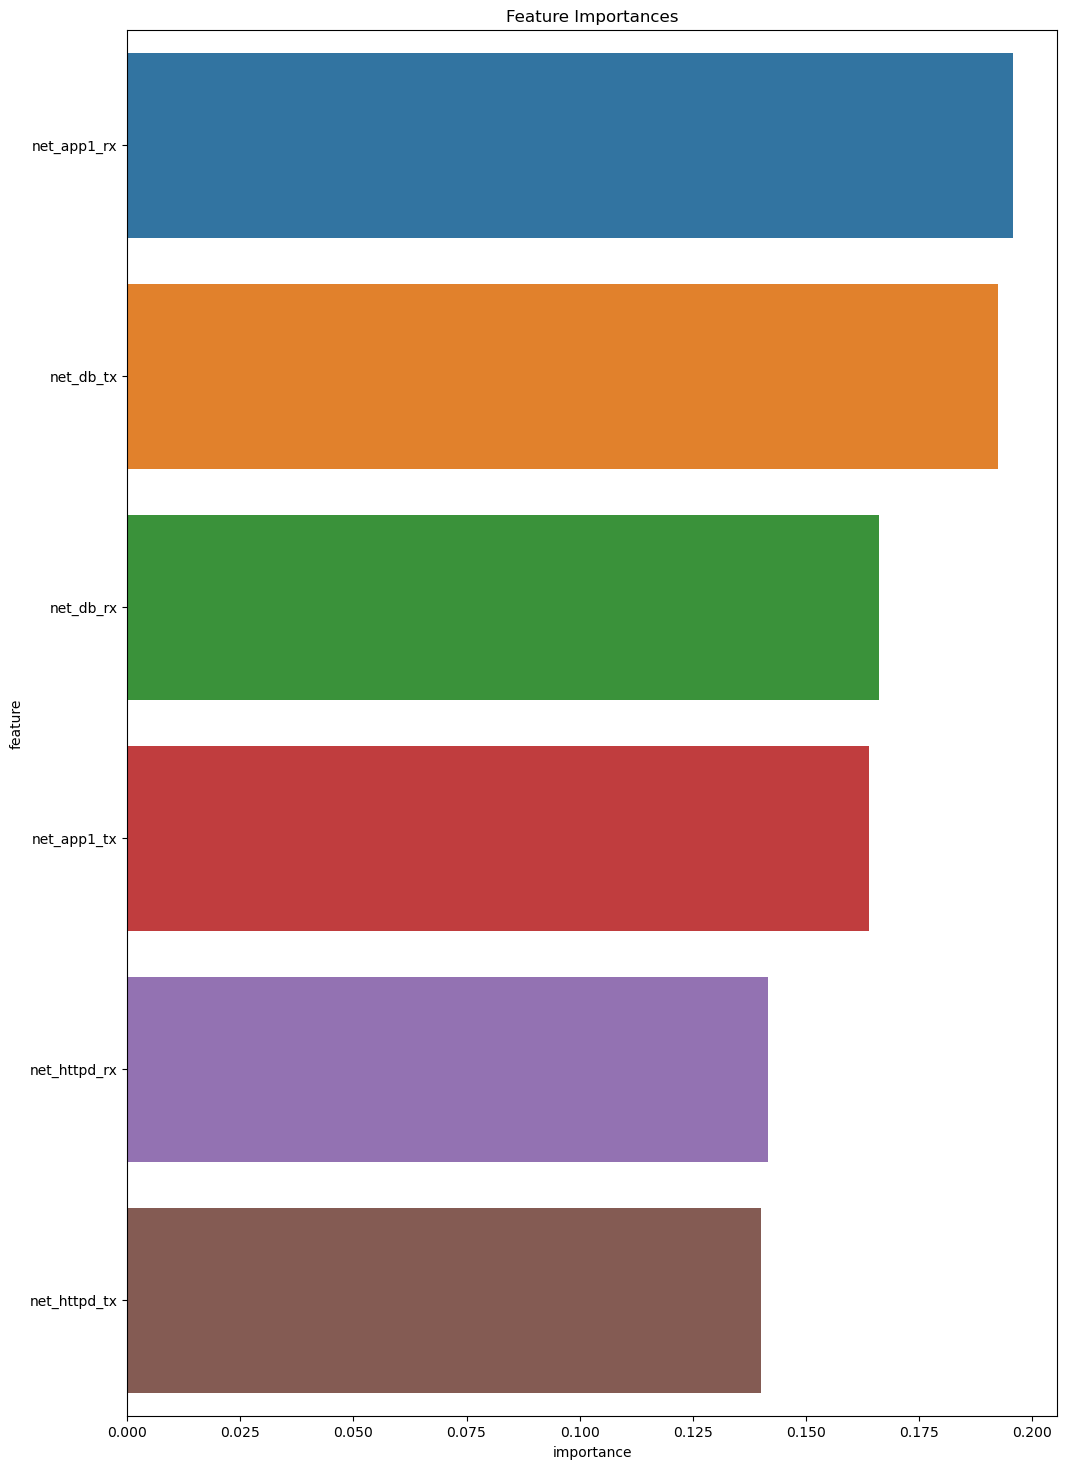

In [7]:
feature_importances = rf.feature_importances_

feature_names = X_val.columns
importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 18))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importances')
plt.show()